# **COVID 19 Impact on Ecommerce ASSIGNMENT**


---



Assignment

---



**Team:** Team Vishleshi


---











## **Abstract**

Foo bar..


---






## **Problem Statement & Business Context**

The details of the problem context and the analytical overview can be found HERE



---









## **Exploratory Data Analysis**

In [1]:
#!pip install gensim
#!pip install wordcloud

### Print Formats & Libraries

In [2]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [3]:
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import os
from matplotlib import pyplot as plt
from scipy.stats import ttest_1samp, ttest_ind, mannwhitneyu, levene, shapiro
from statsmodels.stats.power import ttest_power
from statsmodels.stats.proportion import proportions_ztest
import statsmodels.api as sm
from   statsmodels.formula.api import ols
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import zscore
from sklearn import svm
from platform import python_version
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import itertools
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import nltk
from wordcloud import WordCloud
import glob

print (color.BOLD + color.RED + "Solving for the current objective we will be using python version " + python_version())

Solving for the current objective we will be using python version 3.7.6


### Data Loading

In [4]:
#Reading data from input (in Excel Format) to a Pandas DataFrame
def read_ecommerce_challenges(filename,challenges):
    file1 = open(filename, 'r', encoding = 'utf-8') 
    raw_lines = file1.readlines() 
    for line in raw_lines:
        challenges.append(line.strip())
    return challenges

In [5]:
scrapped_files=glob.glob("*.txt")
challenges=[]
for f in scrapped_files:
    tmp_comments=read_ecommerce_challenges(f,challenges)
data = pd.DataFrame(columns=['ECommerceChallenges'],data=(challenges))
data.head()

print ('Files read !')

Files read !


### Data Exploration & Pre-processing

In [6]:
# Finding Null Values
print(color.BOLD + color.BLUE + str(data.isna().sum()))

ECommerceChallenges    0
dtype: int64


In [7]:
# Finding Unique Values in each of the fields
print(color.BOLD + color.BLUE + str(data.nunique()))

ECommerceChallenges    122
dtype: int64


In [8]:
#Dropping dupliactes for further analysis
data=data.drop_duplicates()
print (color.BOLD+color.BLUE + "The number of records remaining in data is " + str(data.shape[0]))

The number of records remaining in data is 122


#### Length of Fields

In [9]:
#Length of 'Challenges'
challenges_lengths = [len(x) for x in data['ECommerceChallenges']]

print (color.BOLD + color.BLUE +  'Max description length for Challenges comment is {}'.format(max(challenges_lengths)))

Max description length for Challenges comment is 593


In [10]:
#Destribution of Challenges
pd.DataFrame(challenges_lengths).describe(percentiles=[0.1, .25, .5, .75, .95, .99]).transpose()

,count,mean,std,min,10%,25%,50%,75%,95%,99%,max
0,122.0,201.57377,133.812618,0.0,19.0,65.25,218.0,281.5,415.4,530.92,593.0


Distribution of Lenghts [Top 99%]


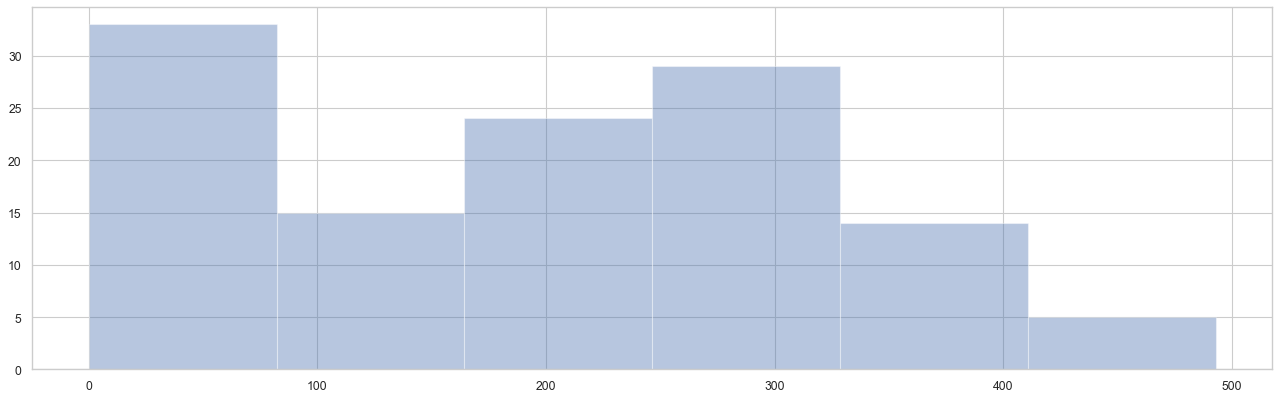

Distribution of Lenghts [All]


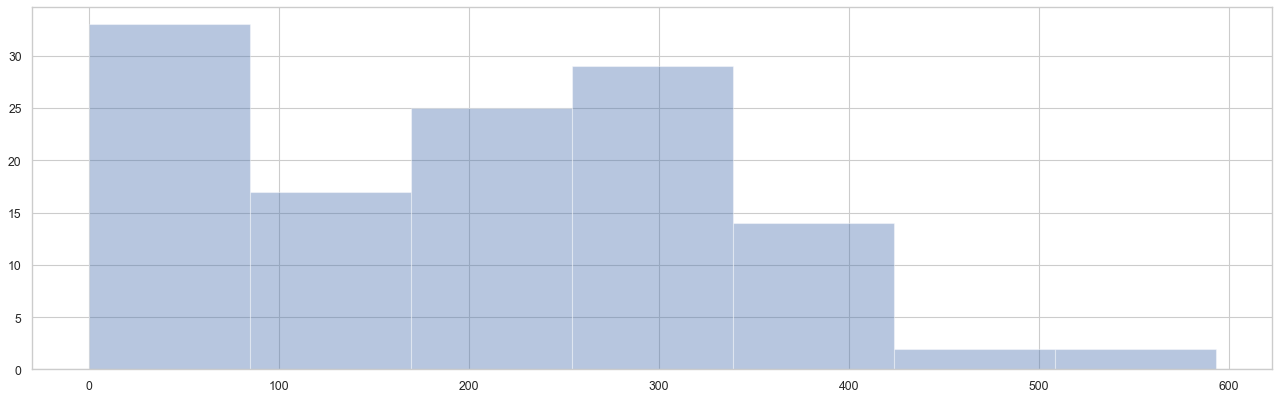

In [11]:
sns.set(style='whitegrid')
from matplotlib.pyplot import figure
figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
print(color.BOLD + color.BLUE + "Distribution of Lenghts [Top 99%]")
sns.distplot(list(filter(lambda x:x<np.percentile(challenges_lengths,99),challenges_lengths)), kde=False)
plt.show()
figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
print(color.BOLD + color.BLUE + "Distribution of Lenghts [All]")
sns.distplot(challenges_lengths, kde=False)
plt.show()

#### Exploring most common words

In [12]:
# Removing special characters

#Carriage Returns & Tabs
data['ECommerceChallenges'].replace(to_replace=[r"\\t|\\n|\\r", "\t|\n|\r"], value=[" "," "], regex=True, inplace=True)


#Special Characters
spec_chars = ["!",'"',"#","%","&","'","(",")",
              "*","+",",","-",".","/",":",";","<",
              "=",">","?","@","[","\\","]","^","_",
              "`","{","|","}","~","–","-"]
for char in spec_chars:
    data['ECommerceChallenges'] = data['ECommerceChallenges'].apply(lambda x:x.replace(char, ' '))

#Extra spaces
data['ECommerceChallenges'].replace('\s+', ' ', regex=True, inplace=True)

In [13]:
#Remove non ASCII words
data['ECommerceChallenges']=data['ECommerceChallenges'].apply(lambda x:x.encode("ascii","ignore").decode())

In [14]:
#Tokenizing
data['ECommerceChallenges']=data['ECommerceChallenges'].apply(lambda x:x.lower().split())

In [25]:
#Removing StopWords
nltk.download('stopwords')
stop=list(stopwords.words('english'))
# Removing Stop Words
stop=stop + ['https']

data['ECommerceChallenges']=data['ECommerceChallenges'].apply(lambda x: [item for item in x if item not in stop])

[nltk_data] Downloading package stopwords to C:\Users\Aditya
[nltk_data]     Jain\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
from collections import Counter
def find_top_unigrams(tokenized_sentences_series, top_number):
  token=[]
  token_freq=[]
  for sentence in tokenized_sentences_series:
    token=token+sentence
  return(Counter(token).most_common(top_number))

def find_all_unigrams(tokenized_sentences_series):
  token=[]
  token_freq=[]
  for sentence in tokenized_sentences_series:
    token=token+sentence
  return(token)

In [17]:
popular_description = pd.DataFrame(find_top_unigrams(data['ECommerceChallenges'],20),columns=['Word','Frequency'])

Top unigrams used to describe challenges


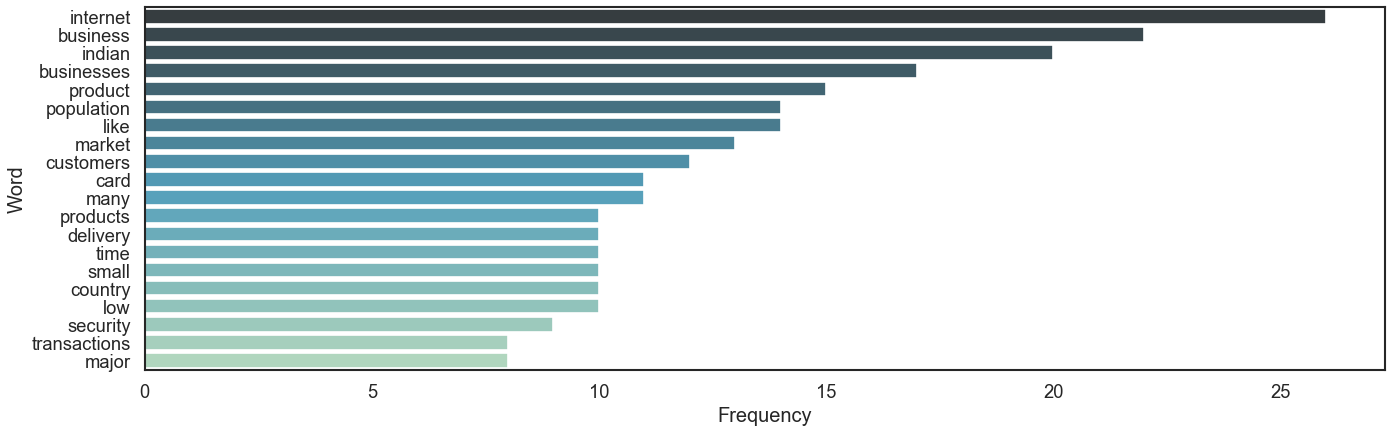

In [18]:
#Barplots
figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='w')
print(color.BOLD + color.PURPLE + "Top unigrams used to describe challenges")
sns.set(style="white", context="talk")
sns.barplot(x=popular_description.Frequency, y=popular_description.Word,  palette="GnBu_d")
plt.show()

Word Cloud for Challenges


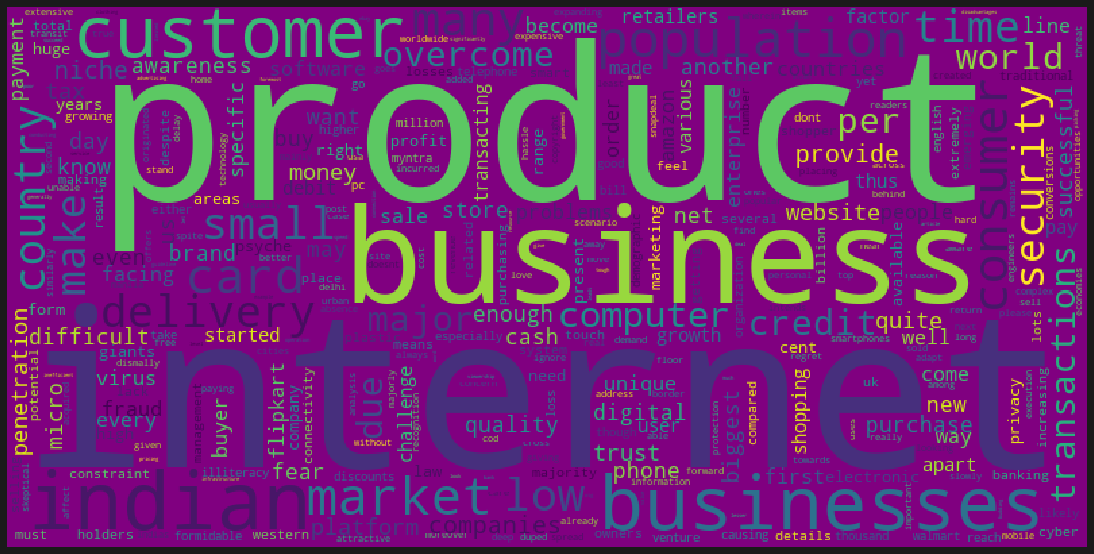

In [19]:
#word clouds
tokens=find_all_unigrams(data['ECommerceChallenges'])
words=""
for word in tokens:
  words+=" "+word


print(color.BOLD + color.BLUE + "Word Cloud for Challenges")

wordcloud = WordCloud(max_words=500, background_color="purple",width=800, height=400,collocations=False).generate(words)
plt.figure(figsize = (15, 15), facecolor = 'k') 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

Word Cloud for Challenges (Using Bigrams)


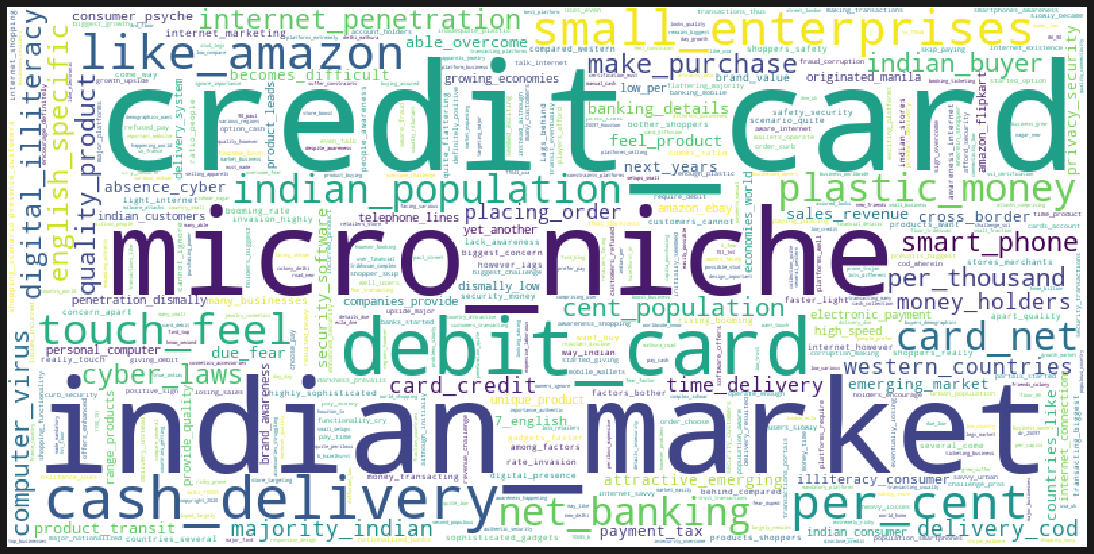

In [20]:
data['ECommerceChallenges_Bigrams']=data['ECommerceChallenges'].apply(lambda row: list(nltk.ngrams(row,2)))
bigram_tokens=[]
for challenge in data['ECommerceChallenges_Bigrams']:
    for word1, word2 in challenge:
        bigram = word1+'_'+word2
        bigram_tokens.append(bigram)
        
words=""
for word in bigram_tokens:
  words+=" "+word

print(color.BOLD + color.BLUE + "Word Cloud for Challenges (Using Bigrams)")

wordcloud = WordCloud(max_words=500, background_color="white",width=800, height=400,collocations=False).generate(words)
plt.figure(figsize = (15, 15), facecolor = 'k') 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()         

Word Cloud for Challenges (Using Trigrams)


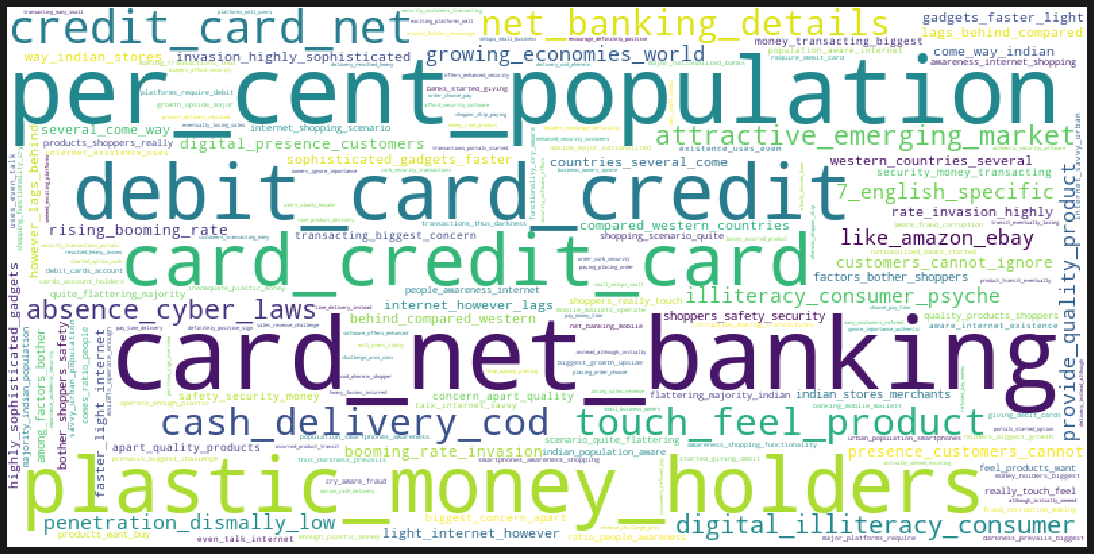

In [21]:
data['ECommerceChallenges_Trigrams']=data['ECommerceChallenges'].apply(lambda row: list(nltk.ngrams(row,3)))
trigram_tokens=[]
for challenge in data['ECommerceChallenges_Trigrams']:
    for word1, word2,word3 in challenge:
        trigram = word1+'_'+word2+'_'+word3
        trigram_tokens.append(trigram)
        
words=""
for word in trigram_tokens:
  words+=" "+word

print(color.BOLD + color.BLUE + "Word Cloud for Challenges (Using Trigrams)")

wordcloud = WordCloud(max_words=500, background_color="white",width=800, height=400,collocations=False).generate(words)
plt.figure(figsize = (15, 15), facecolor = 'k') 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()         

In [22]:
#lemmatized words
nltk.download('wordnet')
stemmer = SnowballStemmer('english')
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

[nltk_data] Downloading package wordnet to C:\Users\Aditya
[nltk_data]     Jain\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [23]:
data['ECommerceChallenges_Lemmatized'] = data['ECommerceChallenges'].apply(lambda x: [lemmatize_stemming(item) for item in x])

In [24]:
data.to_csv('covid19impact.xls')